In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from tensorflow.keras.utils import to_categorical

In [2]:
import os

INPUT_PATH = "./"
EMOTIONS = ["angry", "sad", "happy","relaxed"]

total_images = 0

for dir_ in os.listdir(INPUT_PATH):
    if dir_ in EMOTIONS and os.path.isdir(os.path.join(INPUT_PATH, dir_)):
        count = 0
        dir_path = os.path.join(INPUT_PATH, dir_)
        for f in os.listdir(dir_path):
            if os.path.isfile(os.path.join(dir_path, f)):  # Ensure it's a file
                count += 1
                total_images += 1
        print(f"{dir_} has {count} number of images")

print(f"\nTotal images are {total_images}")

angry has 1000 number of images
happy has 1000 number of images
relaxed has 1000 number of images
sad has 1000 number of images

Total images are 4000


In [3]:
img_arr = np.empty(shape=(total_images, 96, 96, 3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_resized = cv2.resize(img, (96, 96))
            img_arr[i] = img_resized
            img_label[i] = e
            i += 1
        e += 1

img_arr.shape, img_label.shape

((4000, 96, 96, 3), (4000,))

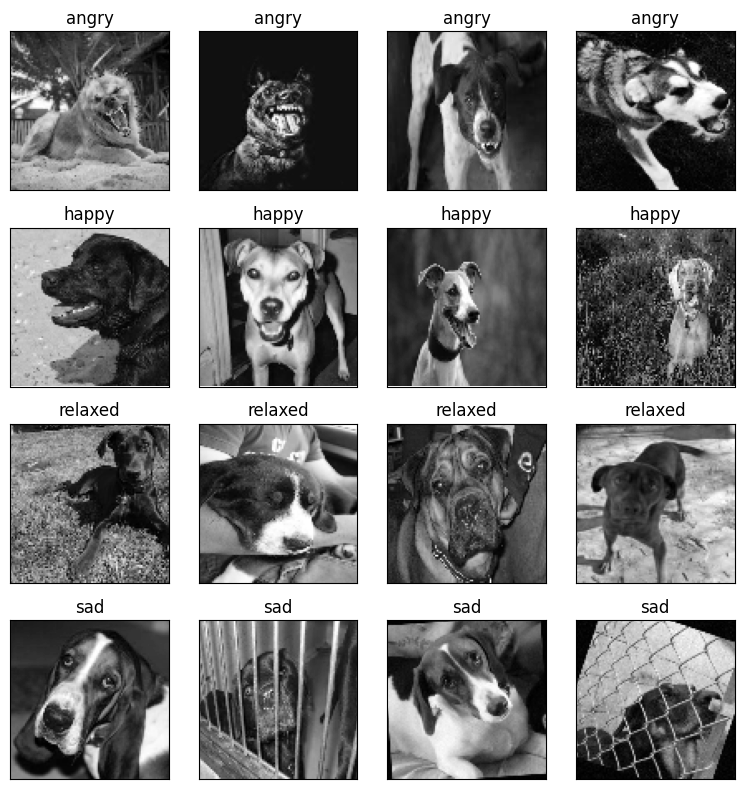

In [4]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [5]:
img_label =to_categorical(img_label)
img_label.shape

(4000, 4)

In [6]:
img_arr = img_arr / 255.

X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, shuffle = True, stratify = img_label, train_size = 0.9, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3600, 96, 96, 3), (400, 96, 96, 3), (3600, 4), (400, 4))

In [7]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [8]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name = "global_pool")(x)
out = Dense(num_classes, activation = "softmax", name = "out_layer")(global_pool)

model = Model(inputs = mobile_net.input, outputs = out)

for layer in model.layers[:15]:
    layer.trainable = False

C:\Users\umesh\AppData\Local\Temp\ipykernel_19604\4033941499.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_net = MobileNet(


In [9]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    zca_whitening = False,
)
train_datagen.fit(X_train)

In [10]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.00008,
    patience = 11,
    verbose = 1,
    restore_best_weights = True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    min_delta = 0.0001,
    factor = 0.25,
    patience = 4,
    min_lr = 1e-7,
    verbose = 1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
batch_size = 25
epochs = 14

optim = optimizers.Nadam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07)

model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optim,
        metrics = ['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size = batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = math.ceil(len(X_train) / batch_size),
    epochs = epochs,
    callbacks = callbacks
)

c:\Users\umesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/14
144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 360ms/step - accuracy: 0.3095 - loss: 3.6288 - val_accuracy: 0.3200 - val_loss: 5.1337 - learning_rate: 0.0100
Epoch 2/14
144/144 ━━━━━━━━━━━━━━━━━━━━ 53s 364ms/step - accuracy: 0.4678 - loss: 1.2813 - val_accuracy: 0.3750 - val_loss: 2.3560 - learning_rate: 0.0100
Epoch 3/14
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 314ms/step - accuracy: 0.5489 - loss: 1.1315 - val_accuracy: 0.3200 - val_loss: 4.3278 - learning_rate: 0.0100
Epoch 4/14
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 295ms/step - accuracy: 0.4934 - loss: 1.2230 - val_accuracy: 0.4100 - val_loss: 2.1749 - learning_rate: 0.0100
Epoch 5/14
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 306ms/step - accuracy: 0.5546 - loss: 1.0717 - val_accuracy: 0.5825 - val_loss: 1.0743 - learning_rate: 0.0100
Epoch 6/14
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 304ms/step - accuracy: 0.5936 - loss: 0.9949 - val_accuracy: 0.6375 - val_loss: 0.9224 - learning_rate: 0.0100
Epoch 7/14
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 305ms/step - accuracy: 0.5

In [12]:
model.save("dog_emotion_model.h5")

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the trained model
MODEL_PATH = "dog_emotion_model.h5"  # Replace with your model's path
model = load_model(MODEL_PATH)

# Define the class names
CLASS_NAMES = ["angry", "happy", "relaxed", "sad"]  # Replace with your class labels

# Path to the single image
IMAGE_PATH = "image.jpg"  # Replace with the path to your image
IMAGE_SIZE = (96,96)  # Replace with the input size of your model

# Load and preprocess the image
image = load_img(IMAGE_PATH, target_size=IMAGE_SIZE)  # Resize the image
image_array = img_to_array(image)  # Convert to a NumPy array
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
image_array = image_array / 255.0  # Normalize pixel values

# Make a prediction
prediction = model.predict(image_array)
predicted_class = np.argmax(prediction, axis=1)[0]
predicted_label = CLASS_NAMES[predicted_class]

# Print the result
print(f"The model predicts the emotion as: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The model predicts the emotion as: angry


In [33]:
import cv2
import numpy as np
import tensorflow as tf

# Load trained emotion detection model
model = tf.keras.models.load_model("dog_emotion_model.h5")
emotion_labels = ["angry", "happy", "relaxed", "sad"]  # Modify based on your model

# Load Haar Cascade for dog face detection (or use a deep learning model)
dog_face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Initialize Kalman Filter
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03

# Start webcam feed
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect dog faces
    faces = dog_face_cascade.detectMultiScale(gray, 1.3, 5)
    print(f"Detected {len(faces)} face(s) in the frame.")

    for (x, y, w, h) in faces:
        # Kalman Filter Prediction
        prediction = kalman.predict()

        # Crop and preprocess face
        face_roi = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_roi, (96, 96))  # Adjust to model input size
        face_array = np.expand_dims(face_resized, axis=0) / 255.0  # Normalize

        # Predict emotion
        prediction = model.predict(face_array)
        emotion = emotion_labels[np.argmax(prediction)]
        print(f"Predicted emotion: {emotion}")

        # Kalman Filter Correction
        measured = np.array([[np.float32(x + w // 2)], [np.float32(y + h // 2)]])
        kalman.correct(measured)
        print(f"Kalman Filter Correction: {measured}")

        # Draw bounding box and emotion label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show frame
    cv2.imshow("Dog Emotion Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0 face(s) in the frame.
Detected 0